<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Code-setup" data-toc-modified-id="Code-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Code setup</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Read-in-data" data-toc-modified-id="Read-in-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Read in data</a></span><ul class="toc-item"><li><span><a href="#Alternate-MW-calculations,-dataframes" data-toc-modified-id="Alternate-MW-calculations,-dataframes-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Alternate MW calculations, dataframes</a></span><ul class="toc-item"><li><span><a href="#Impute-ENM-diameter" data-toc-modified-id="Impute-ENM-diameter-2.1.1.1"><span class="toc-item-num">2.1.1.1&nbsp;&nbsp;</span>Impute ENM diameter</a></span></li><li><span><a href="#Apply-alternate-variables" data-toc-modified-id="Apply-alternate-variables-2.1.1.2"><span class="toc-item-num">2.1.1.2&nbsp;&nbsp;</span>Apply alternate variables</a></span></li></ul></li></ul></li><li><span><a href="#Apply-WF-bins" data-toc-modified-id="Apply-WF-bins-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Apply WF bins</a></span></li></ul></li><li><span><a href="#======TESTING======" data-toc-modified-id="======TESTING======-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>======TESTING======</a></span></li><li><span><a href="#Model-setup" data-toc-modified-id="Model-setup-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model setup</a></span></li><li><span><a href="#SVC-RBF-Models" data-toc-modified-id="SVC-RBF-Models-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>SVC-RBF Models</a></span><ul class="toc-item"><li><span><a href="#ENM-only" data-toc-modified-id="ENM-only-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>ENM-only</a></span><ul class="toc-item"><li><span><a href="#Baseline-model" data-toc-modified-id="Baseline-model-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Baseline model</a></span></li><li><span><a href="#Permutation-test" data-toc-modified-id="Permutation-test-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Permutation test</a></span></li><li><span><a href="#Feature-comparison" data-toc-modified-id="Feature-comparison-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>Feature comparison</a></span></li></ul></li><li><span><a href="#Organics-only" data-toc-modified-id="Organics-only-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Organics-only</a></span></li><li><span><a href="#Randomly-augmented-data" data-toc-modified-id="Randomly-augmented-data-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Randomly augmented data</a></span></li><li><span><a href="#Matching-(unsupervised)-augmented-data" data-toc-modified-id="Matching-(unsupervised)-augmented-data-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Matching (unsupervised) augmented data</a></span></li><li><span><a href="#Matching-(supervised)-augmented-data" data-toc-modified-id="Matching-(supervised)-augmented-data-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Matching (supervised) augmented data</a></span></li><li><span><a href="#Alternative-to-MW" data-toc-modified-id="Alternative-to-MW-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Alternative to MW</a></span><ul class="toc-item"><li><span><a href="#Diameter" data-toc-modified-id="Diameter-5.6.1"><span class="toc-item-num">5.6.1&nbsp;&nbsp;</span>Diameter</a></span><ul class="toc-item"><li><span><a href="#Random-augmentation" data-toc-modified-id="Random-augmentation-5.6.1.1"><span class="toc-item-num">5.6.1.1&nbsp;&nbsp;</span>Random augmentation</a></span></li><li><span><a href="#Unsupervised-matching-augmentation" data-toc-modified-id="Unsupervised-matching-augmentation-5.6.1.2"><span class="toc-item-num">5.6.1.2&nbsp;&nbsp;</span>Unsupervised matching augmentation</a></span></li></ul></li><li><span><a href="#Molar-volume" data-toc-modified-id="Molar-volume-5.6.2"><span class="toc-item-num">5.6.2&nbsp;&nbsp;</span>Molar volume</a></span></li></ul></li></ul></li><li><span><a href="#Random-Forest-Models" data-toc-modified-id="Random-Forest-Models-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Random Forest Models</a></span><ul class="toc-item"><li><span><a href="#ENM-only" data-toc-modified-id="ENM-only-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>ENM-only</a></span></li><li><span><a href="#Randomly-augmented-data" data-toc-modified-id="Randomly-augmented-data-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Randomly augmented data</a></span></li><li><span><a href="#Matching-(unsupervised)-augmented-data" data-toc-modified-id="Matching-(unsupervised)-augmented-data-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Matching (unsupervised) augmented data</a></span></li><li><span><a href="#Matching-(supervised)-augmented-data" data-toc-modified-id="Matching-(supervised)-augmented-data-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Matching (supervised) augmented data</a></span></li></ul></li><li><span><a href="#Performance-Results" data-toc-modified-id="Performance-Results-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Performance Results</a></span><ul class="toc-item"><li><span><a href="#SVC-RBF" data-toc-modified-id="SVC-RBF-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>SVC-RBF</a></span><ul class="toc-item"><li><span><a href="#Permutation-test" data-toc-modified-id="Permutation-test-7.1.1"><span class="toc-item-num">7.1.1&nbsp;&nbsp;</span>Permutation test</a></span></li><li><span><a href="#Significance-testing" data-toc-modified-id="Significance-testing-7.1.2"><span class="toc-item-num">7.1.2&nbsp;&nbsp;</span>Significance testing</a></span></li></ul></li><li><span><a href="#RFC" data-toc-modified-id="RFC-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>RFC</a></span></li></ul></li></ul></div>

# Code setup

In [31]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# To suppress warning output
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Important imports
import numpy as np
from numpy import random
import pandas as pd
import os, sys
import math

# Set random seed across notebook for repeatable results
np.random.seed(42)

In [32]:
# To plot nice figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams['axes.titlesize'] = 'x-large' #16
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'

In [33]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "figs"

if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
    print('Figure directory did not exist, creating now.')
    os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
else:
    print('Figure directory exists.')

Figure directory exists.


In [34]:
# Import classes and functions used across multiple notebooks
sys.path.append(os.getcwd())
import importlib
import functions as blt
importlib.reload(blt);

Figure directory exists.


# Data

## Read in data

In [35]:
# Target (ENM) data

# Read in ENM feature data
X_enm = pd.read_csv("./data/ENM-preprocessed-feats.csv", 
                    sep='\t', header='infer', index_col=0)
# Read in ENM labels (maximum_weight_fraction)
y_enm = pd.read_csv("./data/ENM-clean.csv", 
                    sep=',', header='infer', usecols=[4])
print('X_enm shape:', X_enm.shape)
print('y_enm shape:', y_enm.shape)

X_enm shape: (112, 35)
y_enm shape: (112, 1)


In [36]:
# Source (bulk organics) data

# Read in source feature data
X_source = pd.read_csv("./data/organics-preprocessed-feats.csv", 
                       sep='\t', header='infer', index_col=0)
# Read in source labels (maximum_weight_fraction)
y_source = pd.read_csv("./data/organics-preprocessed-WF.csv", 
                       sep='\t', header='infer', index_col=0)
y_source.index = X_source.index
print('X_source shape:', X_source.shape)
print('y_source shape:', y_source.shape)

X_source shape: (16439, 35)
y_source shape: (16439, 1)


In [37]:
# View ENM feature df
X_enm.head(4)

,cprp_MW,cprp_MP,cprp_logdensity,fagg_absorbent_opacifier,fagg_brightener_viscositymodifier,fagg_filler_humectant,func_UVstabilizer,func_antiadhesivecohesive,func_antioxidant,func_antiredepositionagent,...,pgrp_dentalcare,pgrp_deodorant,pgrp_facialcleansingmoisturizing,pgrp_footcare,pgrp_generalmoisturizing,pgrp_makeuprelated,pgrp_surfacesealers,mtrx_spray,mtrx_formulation,mtrx_WFmeasured
0,79.867,1843.00,0.626340,0.0,0.5,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1,63.546,1083.00,0.952308,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
2,65.370,419.53,0.853698,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
3,107.868,961.78,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0


In [38]:
# Read in previous model evaluation results tables
results_svc = pd.read_csv("./data/results-SVC.csv", sep='\t', na_values='nan')
results_rfc = pd.read_csv("./data/results-RFC.csv", sep='\t')
results_permute = np.loadtxt('./data/results-permutation-SVC.txt')
results_svc_diam = pd.read_csv("./data/results-SVC-diam.csv", 
                               sep='\t', na_values='nan')

### Alternate MW calculations, dataframes

First, we consider the inclusion of "diameter." We lack this data for most ENM CP samples, and all organics CP samples. We will first use imputation to fill ENM data gaps.

#### Impute ENM diameter

In [39]:
# Get list of original features
cols_orig = X_enm.columns.tolist()

# Reinstate diameter feature for X_enm
X_enm['cprp_diameter'] = pd.read_csv("./data/ENM-clean.csv", 
                                     sep=',', header='infer', usecols=[5])
# Define new variable for if ENM diameter was measured [1] or estimated [0]
X_enm['cprp_isdiamprovided'] = 1 * X_enm['cprp_diameter'].notnull()
X_enm['cprp_logdiameter'] = np.log10(X_enm['cprp_diameter'])

In [40]:
# Scatter matrix
import plotly.express as px
fig = px.scatter_matrix(X_enm, 
                        dimensions=["cprp_diameter", "cprp_logdiameter", 
                                    "cprp_MP", "cprp_MW", "cprp_logdensity"])
fig.show()

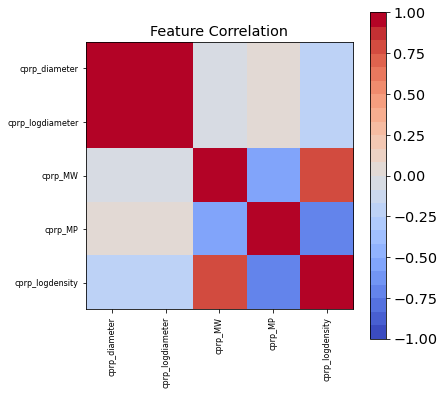

In [41]:
# Get feature correlation to determine best independent variable for imputation
def correlation_matrix(df):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    cmap = cm.get_cmap('coolwarm', 24)
    cax = ax.imshow(df.corr('spearman'), cmap=cmap, vmin=-1, vmax=1)
    plt.title('Feature Correlation')
    labels = df.columns.tolist()
    ax.set_xticks(range(len(df.columns)))
    ax.set_yticks(range(len(df.columns)))
    ax.set_xticklabels(labels,fontsize=8, rotation=90)
    ax.set_yticklabels(labels,fontsize=8)
    fig.colorbar(cax)
    plt.show()
correlation_matrix(X_enm.iloc[:, [35, 37, 0, 1, 2]])

In order to find missing values for diameter, imputation will be performed using linear regression. Log(Density) has the highest correlation with diameter and will therefore be used as the independent variable.
Assuming the line of best fit for a set of points is given by:

$y = a + b x$

where:

$b = \Large{\frac{\sum x_i  y_i - n \bar x\bar y )} {\sum (x_i - \bar x)^2}} $

and

$a = \bar y - b \bar x$

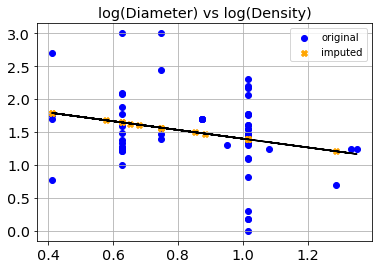

In [42]:
# Find line of best fit for imputation

# MP and density arrays for continuous data
X = np.array(X_enm.loc[X_enm.cprp_logdiameter.notnull(), ['cprp_logdensity']])
Y = np.array(X_enm.loc[X_enm.cprp_logdiameter.notnull(), 
                          ['cprp_logdiameter']])

# Solve for 'a' and 'b'
def best_fit(X, Y):
    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)
    numer = sum(xi*yi for xi,yi in zip(X, Y)) - n * xbar * ybar
    denum = sum(xi**2 for xi in X) - n * xbar**2
    b = numer / denum
    a = ybar - b * xbar
    return a, b

a, b = best_fit(X, Y)

# log(density) and log(diameter) arrays for missing data
X_null = np.array(X_enm.loc[X_enm.cprp_logdiameter.isnull(), ['cprp_logdensity']])
Y_null = b * X_null + a

# Plot points and fit line
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X, Y, c = 'b', label="original")
ax1.scatter(X_null, Y_null, c = 'orange', marker = 'X', label="imputed")
yfit = [a + b * xi for xi in X]
ax1.plot(X, yfit, color='black')

plt.title("log(Diameter) vs log(Density)")
plt.legend(loc='upper right')
plt.grid()
plt.show()

blt.savepdf(fig, "logdiameter_logdensity")

In [43]:
# Put imputed densities into data frame
for idx in X_enm.index:
    if pd.isnull(X_enm.loc[idx,"cprp_diameter"]):
        logDens = X_enm.loc[idx,"cprp_logdensity"]
        X_enm.loc[idx,"cprp_diameter"] = 10 ** (b * logDens + a)

In [44]:
X_enm.iloc[:, [35, 36, 37, 0, 1, 2]]

,cprp_diameter,cprp_isdiamprovided,cprp_logdiameter,cprp_MW,cprp_MP,cprp_logdensity
0,44.454118,0,NaN,79.867,1843.00,0.626340
1,20.000000,1,1.301030,63.546,1083.00,0.952308
2,31.398784,0,NaN,65.370,419.53,0.853698
3,1.500000,1,0.176091,107.868,961.78,1.014730
4,1.500000,1,0.176091,107.868,961.78,1.014730
...,...,...,...,...,...,...
107,35.000000,1,1.544068,107.868,961.78,1.014730
108,30.000000,1,1.477121,107.868,961.78,1.014730
109,40.000000,1,1.602060,107.868,961.78,1.014730
110,24.545033,0,NaN,107.868,961.78,1.014730


#### Apply alternate variables

We will be using "diameter" and molar volume as alternative features for MW (which must also replace density, as this is used in the equation). For comparison with the measured diameters of ENM, the effective "diameter" of an organic compound (assumed to be spherical), $d_{org}$, is calculated as such:

$$
m = \frac{M}{N_A} n \\\
m = \frac{\pi}{6} \rho d_{org}^3 n \\\
d_{org} = \sqrt[3]{\frac{6M}{\pi \rho N_A}} \\\
$$

where $m$ is the mass of a pure material in grams; $M$ is its molecular weight in grams per mole; $N_A = 6.022\mathrm{E}{23}$ molecules per mole, or Avagadros number; $n$ is the number of molecules; and $\rho$ is density in grams per cubic centimeter.

Molar volume, $V_N$, is easily calculated from the above.

$$
V_{N_{org}} = d_{org}^3 N_A = \frac{6M}{\pi\rho} \\\
V_{N_{ENM}} = d_{ENM}^3 N_{ENM} = \frac{6M}{\pi\rho} \\\
$$

The constants may be ignored, simplifying to:

$$
V_{N_{org}} = \frac{M}{\rho} \\\
V_{N_{ENM}} = \frac{M}{\rho} \\\
$$

In [45]:
from scipy import constants

def diameterorg(MW, density):
    diam = ((6 * MW) / (math.pi * density * constants.N_A)) ** (1./3)    
    return diam

def molvolume(MW, density):
    MV = (MW / density)
    return MV

In [46]:
# Undo log tranformation of density
X_enm['cprp_density'] = 10 ** X_enm['cprp_logdensity']
X_source['cprp_density'] = 10 ** X_source['cprp_logdensity']

# Apply new functions to datasets
X_source['cprp_diameter'] = diameterorg(X_source['cprp_MW'], 
                                    X_source['cprp_density'])
X_source['cprp_isdiamprovided'] = 0
X_enm['cprp_MV'] = molvolume(X_enm['cprp_MW'], 
                             X_enm['cprp_density'])
X_source['cprp_MV'] = molvolume(X_source['cprp_MW'], 
                                X_source['cprp_density'])

In [47]:
# Create alternative datasets
cols_new = X_enm.columns.tolist()
cols_diam = ([cols_new[-5]] +   # 'cprp_diameter'
             [cols_new[-4]] +   # 'cprp_isdiamprovided'
             [cols_new[1]] +    # 'cprp_MP'
             cols_new[3:-5])    # all other features
cols_MV = ([cols_new[-1]] +     # 'cprp_MV'
           [cols_new[1]] +      # 'cprp_MP'
           cols_new[3:-5])      # all other features

X_enm_diam = pd.DataFrame(X_enm[cols_diam])
X_enm_MV = pd.DataFrame(X_enm[cols_MV])
X_enm = pd.DataFrame(X_enm[cols_orig])

X_source_diam = pd.DataFrame(X_source[cols_diam])
X_source_MV = pd.DataFrame(X_source[cols_MV])
X_source = pd.DataFrame(X_source[cols_orig])

y_enm_diam = pd.DataFrame(y_enm)
idx = X_enm_diam.index.values.tolist()
y_enm_diam = y_enm_diam.iloc[idx,:]

In [48]:
# Convert ENM diameter units from nanometers to centimeters
X_enm_diam['cprp_diameter'] = X_enm_diam['cprp_diameter'] / 1000000

In [49]:
X_enm.head(10)

,cprp_MW,cprp_MP,cprp_logdensity,fagg_absorbent_opacifier,fagg_brightener_viscositymodifier,fagg_filler_humectant,func_UVstabilizer,func_antiadhesivecohesive,func_antioxidant,func_antiredepositionagent,...,pgrp_dentalcare,pgrp_deodorant,pgrp_facialcleansingmoisturizing,pgrp_footcare,pgrp_generalmoisturizing,pgrp_makeuprelated,pgrp_surfacesealers,mtrx_spray,mtrx_formulation,mtrx_WFmeasured
0,79.867,1843.00,0.626340,0.0,0.5,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1,63.546,1083.00,0.952308,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
2,65.370,419.53,0.853698,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
3,107.868,961.78,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0
4,107.868,961.78,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
5,107.868,961.78,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
6,107.868,961.78,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
7,107.868,961.78,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
8,107.868,961.78,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
9,107.868,961.78,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


## Apply WF bins

Labels (continuous WF data) will be binned into low (0.0-0.0001), medium (0.0001-0.01) and high (0.01-1.0) categories.

In [50]:
# Apply bins to ENM and organics data
bin_enm = np.asarray(y_enm.apply(blt.bins, axis=1))
bin_enm_diam = np.asarray(y_enm_diam.apply(blt.bins, axis=1))
bin_source = np.asarray(y_source.apply(blt.bins, axis=1))

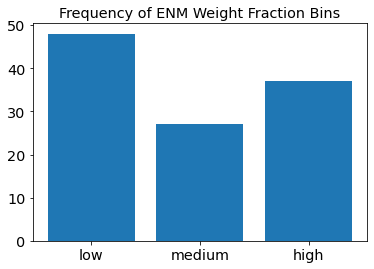

Label bin:  [0 1 2]
Count    :  [48 27 37]
Frequency:  [0.43, 0.24, 0.33]


In [51]:
# View bar plot of ENM WF bins
blt.bar_graph_bins(bin_enm, data_composition='ENM')

The medium WF bin has the least number of samples. This is important for evaluating models later on; the smallest bin size will be used for the number of cross validation folds so that it's essentially "leave-one-out" CV. This approach is, for the most part, considered unbiased.

https://stats.stackexchange.com/questions/154830/10-fold-cross-validation-vs-leave-one-out-cross-validation

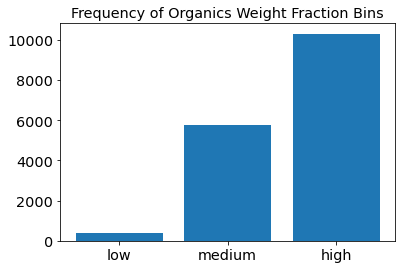

Label bin:  [0 1 2]
Count    :  [  381  5746 10312]
Frequency:  [0.02, 0.35, 0.63]


In [52]:
# View bar plot of Organics WF bins
blt.bar_graph_bins(bin_source, data_composition='Organics')

In [53]:
len(X_source)

16439

# ======TESTING======

In [54]:
import random as pyrandom
from numpy import random
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import MinMaxScaler


# Functions for different data augmentation methods

def no_augment(k, X_source, y_source, random_state, X, y):
    return X, y


def random_augment(k, X_source, y_source, random_state, X, y):
    """Randomly samples source data to pair with target data."""
    
    if k == 0:
        return X, y
    
    pyrandom.seed(random_state)
    
    assert X.shape[0] == y.shape[0], f"X.shape={X.shape}, y.shape={y.shape}"

    # Number of samples to select
    n_samples = k * len(X)
    # Obtain indices for randomly sampling source data
    idx_match = np.random.choice(len(X_source), n_samples)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match,:]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))
    assert X_aug.shape[0] == y_aug.shape[0], f"X_aug.shape={X_aug.shape}, y_aug.shape={y_aug.shape}"
    
    return X_aug, y_aug


def unsupervised_augment(k, X_source, y_source, random_state, X, y):
    """
    Unsupervised data augmentation
    
    Match "k" most similar source data samples to target data samples 
    based on the smallest cosine distance between target and source data 
    samples (i.e., in an supervised fashion).
    """
    
    if k == 0:
        return X, y
    
    pyrandom.seed(random_state)
    
    # Cosine distance matrix
    cosdist_samples = cosine_distances(X_source, X)
    # Loop over distance matrix in search of k-smallest distances
    idx_match = []
    for col in cosdist_samples.T:
        # Find organics data indices of k-smallest distances
        matches = np.argpartition(col, k)[:k]
        idx_match.extend(matches)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match,:]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))
    
    return X_aug, y_aug

def supervised_augment(k, X_source, y_source, random_state, X, y):
    """
    Supervised data augmentation
    
    Match "k" most similar source data samples to target data samples 
    based on the smallest average of cosine distance between samples 
    and distance between WF labels (i.e., in an supervised fashion).
    """
        
    if k == 0:
        return X, y
    
    pyrandom.seed(random_state)
    
    # Cosine distance matrix
    cosdist_samples = cosine_distances(X_source, X)
    # For supervised matching augmentation, also consider WF labels
    # Turn 1D label arrays into 2D arrays
    y_2d = np.tile(y, (len(y_source), 1))
    y_source_2d = np.tile(y_source, (len(y), 1)).transpose()
    # Get normalized distance between ENM and organics labels
    scaler = MinMaxScaler()
    dist_y = scaler.fit_transform(np.abs(y_2d - y_source_2d).astype(float))
    # Average distances of features and labels
    dist_matrix = (0.95 * cosdist_samples) + (0.05 * dist_y)
    # Loop over distance matrix in search of k-smallest distances
    idx_match = []
    for col in dist_matrix.T:
        # Find organics data indices of k-smallest distances
        matches = np.argpartition(col, k)[:k]
        idx_match.extend(matches)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match,:]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))
    
    return X_aug, y_aug

In [55]:
from sklearn.base import BaseEstimator, TransformerMixin

class TrainingDataAugmenter(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        augmentation_type=None,
        k=None,
        X_source=None,
        y_source=None,
        random_state=None,
    ):
        self.augmentation_type = augmentation_type
        self.k = k
        self.X_source = X_source
        self.y_source = y_source
        self.random_state = random_state
        self.y = None

    def fit(self, X, y=None):
        self.y = y
        return self

    def transform(self, X):
        return self.augmentation_type(
            self.k,
            self.X_source,
            self.y_source,
            self.random_state,
            X,
            self.y,
        )

In [56]:
# For use with estimator after augmentation in pipeline
def wrap_estimator(estimator):
    """
    Creates class from estimator.
    
    For dealing with the issue of custom tranformers within pipelines
    that change X and Y.
    https://stackoverflow.com/questions/34727463/scikit-learn-custom-transformer-pipeline-that-changes-x-and-y
    """
    
    def fit(self, X, y=None):
        if isinstance(X, tuple):
            X, y = X
        return estimator.fit(self, X, y)
    def predict(self, X):
        if isinstance(X, tuple):
            X, y = X
        return estimator.predict(self, X)
    def predict_log_proba(self, X):
        if isinstance(X, tuple):
            X, y = X
        return estimator.predict_log_proba(self, X)
    def predict_proba(self, X):
        if isinstance(X, tuple):
            X, y = X
        return estimator.predict_proba(self, X)
    def score(self, X, y, sample_weight=None):
        if isinstance(X, tuple):
            X, y = X
        return estimator.score(self, X, y, sample_weight=sample_weight)

    return type(f"Wrapped{estimator.__name__}", (estimator,), {
        "fit": fit,
        "predict": predict,
        "predict_proba": predict_proba,
        "predict_log_proba": predict_log_proba,
        "score": score,
    })

In [57]:
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import multiprocessing

class EstimatorSelectionHelper:
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score

def apply_model_opt(classifiers,
                    params, 
                    X_target=X_enm,
                    y_target=bin_enm, 
                    random_state=random.randint(1,100)):
    
    """
    Optimize classifier parameters.
    
    Returns table of performance results across a grid of parameters.
    """     

    # Set smallest class size as number of CV folds for leave-one-out CV
    _, class_counts = np.unique(y_target, return_counts=True)
    num_folds = min(class_counts)
    if num_folds > 20: num_folds = 10
    else: num_folds = num_folds

    # Apply
    helper = EstimatorSelectionHelper(classifiers, params)
    helper.fit(X_target, y_target, n_jobs=1, cv=num_folds, scoring='balanced_accuracy')
    results = helper.score_summary(sort_by='mean_score')
    
    return results

In [59]:
WrappedSVC = wrap_estimator(SVC)
WrappedRFC = wrap_estimator(RandomForestClassifier)

random_state = 42
models = {
    'RandomForestClassifier': Pipeline([
        ('scale', MinMaxScaler()), # normalization from 0 to 1
        ('augment', TrainingDataAugmenter(X_source=X_source, 
                                          y_source=bin_source, 
                                          random_state=random_state)),
        ('estimator', WrappedRFC(class_weight='balanced', 
                                 random_state=random_state)),
    ]),
    'SVC': Pipeline([
        ('scale', MinMaxScaler()), # normalization from 0 to 1
        ('augment', TrainingDataAugmenter(X_source=X_source, 
                                          y_source=bin_source, 
                                          random_state=random_state)),
        ('estimator', WrappedSVC(kernel='rbf', 
                                 class_weight='balanced', # balance by class size
                                 random_state=random_state)),
    ]),
}
params = {
    'RandomForestClassifier': {
        'augment__k': [0,1], 
        'augment__augmentation_type': [no_augment, unsupervised_augment],
        'estimator__max_depth': np.arange(4,14,4), 
        'estimator__n_estimators': [40,100],
    },
    'SVC': {
        'augment__k': [0,1], 
        'augment__augmentation_type': [no_augment, unsupervised_augment],
        'estimator__C': np.logspace(-1,7,5), 
        'estimator__gamma': np.logspace(-7,1,5), 
    }
}

In [60]:
# Single trial SVC-RBF, balanced accuracy
apply_model_opt(models, params, X_target=X_enm, y_target=bin_enm)

Running GridSearchCV for RandomForestClassifier.
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ValueError: Found input variables with inconsistent numbers of samples: [12, 24]

# Model setup

The main prediction model function, <b>blt.model_opt_exe</b>, optimizes, executes and evaluates a classifier using stratified CV. It has the option to augment the training data within the pipeline. It is defined in an external file called at the beginning of this script.

The first part of the <b>blt.model_opt_exe</b> function runs a pipeline that normalizes features on a 0 to 1 scale then performs data augmentation and runs a classifer (SVC-RBF or RFC) using leave-one-out cross validation. Model parameters are optimized using a custom parameter grid search, with the optional aid of plots to visualize accuracy over the grid.

The final pipeline (trained using augmented data) is tested on the original ENM data using stratified cross-validation with n_folds = n_samples in the smallest WF bin--essentially leave-one-out CV (discussed earlier). A confusion matrix summarizes accuracy results according to each WF bin ("class"). The average normalized accuracy across all bins is then calculated from the confusion matrix and written to a results table for every data set.

# SVC-RBF Models

## ENM-only

### Baseline model

In [ ]:
# Single trial SVC-RBF, balanced accuracy
param_grid = {'estimator__C': np.logspace(-1,7,9), 
              'estimator__gamma': np.logspace(-7,1,9)
             }
blt.model_opt_exe(classifier='svc', 
                  aug_type='none', 
                  k=0, 
                  feat_data=X_enm, 
                  bin_data=bin_enm, 
                  seed=28, 
                  save_fig_name='enm-only', 
                  show_opt_plot=True, 
                  show_feat_impt=False, 
                  show_cnf_matrix=True, 
                  use_balanced_accu=True, # Balanced accuracy
                  param_grid=param_grid)

In [ ]:
# 30 trials SVC-RBF, balanced accuracy
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[1,1:3] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params, 
                                           print_results=True)

In [ ]:
# 30 trials SVC-RBF, balanced accuracy
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[1,1:3] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params, 
                                           print_results=True)

In [ ]:
# 50 trials SVC-RBF, balanced accuracy
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
blt.multi_trials(num_trials=50, 
                 model_params=model_params, 
                 print_results=True)

In [ ]:
# Save balanced accuracy results for later evaluation
base_distrib = [0.72, 0.7, 0.7, 0.72, 0.72, 0.71, 0.72, 0.7, 0.72, 0.72, 
                0.71, 0.73, 0.71, 0.7, 0.71, 0.72, 0.71, 0.72, 0.7, 0.71, 
                0.7, 0.72, 0.73, 0.73, 0.7, 0.72, 0.71, 0.71, 0.71, 0.7, 
                0.72, 0.71, 0.72, 0.74, 0.71, 0.71, 0.7, 0.72, 0.71, 0.71, 
                0.71, 0.73, 0.72, 0.71, 0.71, 0.72, 0.73, 0.73, 0.71, 0.69]

In [ ]:
# 50 trials SVC-RBF, normal accuracy
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': False, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
blt.multi_trials(num_trials=50, model_params=model_params)

Balanced accuracy performed negligibly better, but makes more sense to use given the imbalance of data between WF bins. Therefore, it will be used throughout.

### Permutation test

The following tests are performed with randomly permuted labels (ENM data only).

In [ ]:
# TODO: Decorator allows selective application of completion "pings"
notify_on_complete = blt.CompletionNotifier(blt.ping_notify)

In [ ]:
@notify_on_complete
def perm_test(num_trials, classifier, model_params):
    seed_set = np.random.choice(np.arange(0,100), 
                                size=num_trials, replace=False)
    results_permute = np.empty(seed_set.size)
    for idx, s in enumerate(seed_set):
        with blt.HiddenPrints():
            bin_enm_permute = np.random.RandomState(seed=s).permutation(bin_enm)
            results_permute[idx] = blt.model_opt_exe(classifier=classifier, 
                                                     aug_type='none', 
                                                     k=0, 
                                                     feat_data=X_enm, 
                                                     bin_data=bin_enm_permute,
                                                     param_grid=param_grid)
    mu_permute = results_permute.mean()
    sigma_permute = results_permute.std()
    print("Avg accuracy:    ", mu_permute)
    print("Median accuracy: ", np.median(results_permute))
    print("StdDev accuracy: ", sigma_permute)
    print("Numer of trials: ", num_trials)
    print("Results: ", results_permute)
    return mu_permute, sigma_permute

In [ ]:
# Run permutation tests over a number of trials, "num_trials"
num_trials = 100
param_grid = {'estimator__C': np.logspace(-1,7,9), 
              'estimator__gamma': np.logspace(-7,1,9)
             }
mu_permute, sigma_permute = perm_test(100, 'svc', model_params=param_grid)

In [ ]:
results_svc.iloc[0,1:3] = (mu_permute, sigma_permute)

In [ ]:
results_permute = [0.36, 0.39, 0.39, 0.45, 0.4, 0.42, 0.32, 0.48, 0.42, 0.43, 
                   0.34, 0.4, 0.38, 0.47, 0.34, 0.34, 0.41, 0.34, 0.34, 0.42, 
                   0.48, 0.35, 0.37, 0.41, 0.39, 0.38, 0.46, 0.47, 0.48, 0.39, 
                   0.45, 0.4, 0.43, 0.42, 0.41, 0.47, 0.41, 0.34, 0.38, 0.38, 
                   0.39, 0.35, 0.46, 0.44, 0.38, 0.35, 0.42, 0.37, 0.33, 0.44, 
                   0.39, 0.44, 0.47, 0.45, 0.39, 0.35, 0.43, 0.5, 0.34, 0.38, 
                   0.34, 0.43, 0.34, 0.36, 0.37, 0.54, 0.37, 0.34, 0.42, 0.49, 
                   0.41, 0.39, 0.35, 0.42, 0.46, 0.42, 0.43, 0.41, 0.43, 0.39, 
                   0.33, 0.38, 0.48, 0.36, 0.43, 0.34, 0.42, 0.45, 0.45, 0.47, 
                   0.33, 0.43, 0.42, 0.48, 0.38, 0.4, 0.44, 0.35, 0.4, 0.34]

In [ ]:
# Export permutation results to text file
np.savetxt('./data/results-permutation-SVC.txt', results_permute, 
           delimiter='\t', fmt='%.2f')

### Feature comparison

Next, model optimization and evaluation is performed on the clustered ENM-only data after it is separated by groups of features: functions, PUCs, chemical properties and matrix properties. This serves as a means of comparing the usefulness of the different feature groups while using an SVC-RBF. A similar comparison is made later by calculating feature importance with the RFC.

##### Only chemical properties

In [ ]:
# Get column indices for features present in Isaacs et al. 2016
feat_names = X_enm.columns
idx_cprponly = [i for i, s in enumerate(feat_names) if 'cprp' in s]

In [ ]:
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,idx_cprponly], 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
mu_func, sigma_func = blt.multi_trials(num_trials=30, 
                                       model_params=model_params, 
                                       print_results=True)

##### Only functional uses

In [ ]:
# Get column indices for features present in Isaacs et al. 2016
idx_funconly = [i for i, s in enumerate(feat_names) if 'fagg' in s]
idx_funconly += [i for i, s in enumerate(feat_names) if 'func' in s]
idx_funconly

In [ ]:
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,idx_funconly], 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
mu_func, sigma_func = blt.multi_trials(num_trials=30, 
                                       model_params=model_params, 
                                       print_results=True)

##### Only chemical properties, functional uses

In [ ]:
# Get column indices for features present in Isaacs et al. 2016
feat_names = X_enm.columns
idx_isaacs = [i for i, s in enumerate(feat_names) if 'cprp' in s]
idx_isaacs += [i for i, s in enumerate(feat_names) if 'fagg' in s]
idx_isaacs += [i for i, s in enumerate(feat_names) if 'func' in s]
idx_isaacs

In [ ]:
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,idx_isaacs], 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
mu_func, sigma_func = blt.multi_trials(num_trials=30, 
                                       model_params=model_params, 
                                       print_results=True)

##### No 'was_WF_measured'

In [ ]:
idx_nomeas = [i for i, s in enumerate(feat_names) if 'WFmeasured' not in s]
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,idx_nomeas], 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
blt.multi_trials(num_trials=30, 
                 model_params=model_params, 
                 print_results=True)

##### No PUCs 

In [ ]:
# Get column indices excluding those of PUCs
counting = np.arange(0,35)
lst = list(counting[:16]) + list(counting[-3:])
lst

In [ ]:
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,lst], 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
mu_func, sigma_func = blt.multi_trials(num_trials=30, 
                                       model_params=model_params)

## Organics-only

In [ ]:
# Run model_opt_exe on clustered organics-only data
param_grid = {'estimator__C': np.logspace(-1,7,9), 
              'estimator__gamma': np.logspace(-7,1,9)
             }
blt.model_opt_exe(classifier='svc', 
                  aug_type='none', 
                  k=0, 
                  feat_data=X_source, 
                  bin_data=bin_source, 
                  show_opt_plot=True, param_grid=param_grid)

## Randomly augmented data
The remaining models use augmented training data.

In [ ]:
# 1:1 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'random', 
                'k': 1, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[2,1:3] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params)

In [ ]:
# 1:2 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'random', 
                'k': 2,
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[3,1:3] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params)

In [ ]:
# 1:3 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'random', 
                'k': 3, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[4,1:3] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params)

In [ ]:
# 1:4 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'random', 
                'k': 4, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[5,1:3] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params)

In [ ]:
# 1:5 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'random', 
                'k': 5, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[6,1:3] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params)

In [ ]:
# 1:10 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'random', 
                'k': 10, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[7,1:3] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

In [ ]:
# 1:20 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'random', 
                'k': 20, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[8,1:3] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

## Matching (unsupervised) augmented data

In [ ]:
# 1:1 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'uns_match', 
                'k': 1, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[2,3:5] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params)

In [ ]:
# 1:2 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'uns_match', 
                'k': 2, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[3,3:5] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params)

In [ ]:
# 1:3 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'uns_match', 
                'k': 3, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[4,3:5] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params)

In [ ]:
# 1:4 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'uns_match', 
                'k': 4, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[5,3:5] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params)

In [ ]:
# 1:5 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'uns_match', 
                'k': 5, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
blt.multi_trials(num_trials=50, 
                 print_results=True, 
                 model_params=model_params)

In [ ]:
# Single trial SVC-RBF, balanced accuracy
param_grid = {'estimator__C': np.logspace(-1,7,9), 
              'estimator__gamma': np.logspace(-7,1,9)
             }
blt.model_opt_exe(classifier='svc', 
                  aug_type='uns_match', 
                  k=5, 
                  feat_data=X_enm, 
                  bin_data=bin_enm, 
                  seed=28, 
                  save_fig_name='uns_match', 
                  show_opt_plot=True, 
                  show_feat_impt=False, 
                  show_cnf_matrix=True, 
                  use_balanced_accu=True, # Balanced accuracy 
                  param_grid=param_grid)

In [ ]:
match_distrib = [0.77, 0.74, 0.76, 0.76, 0.75, 0.76, 0.76, 0.76, 0.73, 0.76, 
                 0.75, 0.74, 0.75, 0.74, 0.76, 0.75, 0.72, 0.75, 0.76, 0.73, 
                 0.75, 0.76, 0.76, 0.77, 0.76, 0.75, 0.75, 0.76, 0.76, 0.76, 
                 0.78, 0.76, 0.74, 0.76, 0.76, 0.72, 0.72, 0.76, 0.76, 0.76, 
                 0.76, 0.76, 0.78, 0.76, 0.74, 0.76, 0.77, 0.76, 0.76, 0.76]

In [ ]:
# 1:10 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'uns_match', 
                'k': 10, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[7,3:5] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

In [ ]:
# 1:20 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'uns_match', 
                'k': 20, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[8,3:5] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

## Matching (supervised) augmented data

In [ ]:
# 1:1 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'sup_match', 
                'k': 1, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[2,5:7] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

In [ ]:
# 1:2 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'sup_match', 
                'k': 2, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[3,5:7] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

In [ ]:
# 1:3 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'sup_match', 
                'k': 3, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[4,5:7] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

In [ ]:
# 1:4 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'sup_match', 
                'k': 4, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[5,5:7] = blt.multi_trials(num_trials=30, print_results=True, 
                                           model_params=model_params)

In [ ]:
# 1:5 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'sup_match', 
                'k': 5, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[6,5:7] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

In [ ]:
# 1:10 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'sup_match', 
                'k': 10, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[7,5:7] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

In [ ]:
# 1:20 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'sup_match', 
                'k': 20, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[8,5:7] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

## Alternative to MW

### Diameter

In [ ]:
results_svc_diam

In [ ]:
# 30 trials SVC-RBF, diameter
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm_diam, 
                'bin_data': bin_enm_diam, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc_diam.iloc[0,1:3] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

#### Random augmentation

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['aug_type'] = "random"
model_params['k'] = 1
results_svc_diam.iloc[1,1:3] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['aug_type'] = "random"
model_params['k'] = 2
results_svc_diam.iloc[2,1:3] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['aug_type'] = "random"
model_params['k'] = 3
results_svc_diam.iloc[3,1:3] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['aug_type'] = "random"
model_params['k'] = 4
results_svc_diam.iloc[4,1:3] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['aug_type'] = "random"
model_params['k'] = 5
results_svc_diam.iloc[5,1:3] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['aug_type'] = "random"
model_params['k'] = 10
results_svc_diam.iloc[6,1:3] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['k'] = 20
results_svc_diam.iloc[7,3:5] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

#### Unsupervised matching augmentation

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['aug_type'] = "uns_match"
model_params['k'] = 1
results_svc_diam.iloc[1,3:5] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['k'] = 2
results_svc_diam.iloc[2,3:5] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params = {'classifier': 'svc', 
                'aug_type': 'uns_match', 
                'k': 3, 
                'feat_data': X_enm_diam, 
                'bin_data': bin_enm_diam, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
model_params['k'] = 3
results_svc_diam.iloc[3,3:5] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['k'] = 4
results_svc_diam.iloc[4,3:5] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['k'] = 5
results_svc_diam.iloc[5,3:5] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['k'] = 10
results_svc_diam.iloc[6,3:5] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

### Molar volume

In [ ]:
# 30 trials SVC-RBF, molar volume
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm_MV, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
blt.multi_trials(num_trials=30, 
                 model_params=model_params, 
                 print_results=True)

In [ ]:
# 30 trials SVC-RBF, molar volume
model_params['aug_type'] = "uns_match"
model_params['k'] = 2
blt.multi_trials(num_trials=30, 
                 model_params=model_params, 
                 print_results=True)

In [ ]:
# 30 trials SVC-RBF, molar volume
model_params['k'] = 5
blt.multi_trials(num_trials=30, 
                 model_params=model_params, 
                 print_results=True)

# Random Forest Models

RFC did not perform as well as SVC in preliminary tests. RFC models here are being used as another way to look at the usefulness (i.e., importance) of different feature groups.

## ENM-only

In [ ]:
# Single trial RFC optimizing max_depth and n_estimators (highly variable)
param_grid = {'estimator__max_depth': np.arange(1,31,1), 
              'estimator__n_estimators': np.arange(40,120,20)}
acc, impt = blt.model_opt_exe(classifier='rfc', 
                              aug_type='none', 
                              k=0, 
                              feat_data=X_enm, 
                              bin_data=bin_enm, 
                              show_opt_plot=True, 
                              show_feat_impt=False, 
                              show_cnf_matrix=False, 
                              param_grid=param_grid)

In [ ]:
# Single trial RFC optimizing max_depth and n_estimators (highly variable)
# Smaller parameter grid
param_grid = {'estimator__max_depth': np.arange(2,15,1), 
              'estimator__n_estimators': [40, 100]}
acc, impt = blt.model_opt_exe(classifier='rfc', 
                              aug_type='random', 
                              k=5, 
                              feat_data=X_enm, 
                              bin_data=bin_enm, 
                              show_opt_plot=True, 
                              show_feat_impt=False, 
                              show_cnf_matrix=False, 
                              param_grid=param_grid)

The contour plots for parameter optimization show that balanced accuracy does not vary much by n_estimators, so we will only test two. Balanced accuracy also seems to stop improving at max_depths beyond 10, so the max_depth range will be set from 4 to 14.

In [ ]:
# 30 trials RFC optimizing max_depth and n_estimators 
model_params = {'classifier': 'rfc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__max_depth': np.arange(4,12,1), 
                               'estimator__n_estimators': [40,100]}
               }
mu_rfc, sigma_rfc, avg_impt, var_impt = \
    blt.multi_trials(num_trials=30, model_params=model_params)

In [ ]:
# Save results to table
results_rfc.loc[results_rfc['ENM-Organics-Ratio']=='1:0', 
    ['Avg-Random-Augment','Std-Random-Augment']] = [mu_rfc, sigma_rfc]

In [ ]:
blt.plot_feat_impt(feat_names=X_enm.columns.values, 
                   importances=avg_impt, 
                   save_fig_name='ENM_RFC', 
                   variances=var_impt, 
                   combo_impt=False)

In [ ]:
blt.plot_feat_impt(feat_names=X_enm.columns.values, 
                   importances=avg_impt, 
                   save_fig_name='ENM_RFC_combo', 
                   variances=var_impt, 
                   combo_impt=True)

## Randomly augmented data

In [ ]:
rfc_param_grid = {'estimator__max_depth': np.arange(4,12,1), 
                  'estimator__n_estimators': [40,100]}

In [ ]:
# 1:1
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 1, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[2,1:3] = a, b

In [ ]:
# 1:2
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 2, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[3,1:3] = a, b

In [ ]:
# 1:3
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 3, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[4,1:3] = a, b

In [ ]:
# 1:4
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 4, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[5,1:3] = a, b

In [ ]:
# 1:5
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 5, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[6,1:3] = a, b

In [ ]:
# 1:10
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 10, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[7,1:3] = a, b

In [ ]:
# 1:20
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 20, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[8,1:3] = a, b

## Matching (unsupervised) augmented data

In [ ]:
# 1:1
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 1, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[2,3:5] = a, b

In [ ]:
# 1:2
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 2, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[3,3:5] = a, b

In [ ]:
# 1:3
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 3, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[4,3:5] = a, b

In [ ]:
# 1:4
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 4, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[5,3:5] = a, b

In [ ]:
# 1:5
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 5, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[6,3:5] = a, b

In [ ]:
# 1:10
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 10, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[7,3:5] = a, b

In [ ]:
# 1:20
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 20, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[8,3:5] = a, b

## Matching (supervised) augmented data

In [ ]:
# 1:1
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 1, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[2,5:7] = a, b

In [ ]:
# 1:2
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 2, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[3,5:7] = a, b

In [ ]:
# 1:3
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 3, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[4,5:7] = a, b

In [ ]:
# 1:4
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 4, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[5,5:7] = a, b

In [ ]:
# 1:5
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 5, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[6,5:7] = a, b

In [ ]:
# 1:10
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 10, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[7,5:7] = a, b

In [ ]:
# 1:20
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 20, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[8,5:7] = a, b

# Performance Results

The following two table summarize the average balanced accuracy for the 1) SVC-RBF models and 2) RFC models on all training data iterations.
* 'ENM-Organics-Ratio' describes the ratio of ENM data to organics data used for augmentation. 
* An ENM-Organics-Ratio with ( * ) indicates that the labels were randomly permuted
* 'Match-Feature-Augment' is average balanced accuracy across all bins for data frames with ENM data augmented with organics data based on the closest matching features.
* 'Avg-Unsupervised-Match' is average accuracy across all bins for data frames with ENM data augmented with organics data based on the closest matching features AND labels (weighted 1:1).
* The second trial (B) of the ENM-only data (1:0 ratio) is with different a different parameter grid for optimizing the SVC-RBF.

Matching augmentation was not performed on data frames only containing ENM data (non-permuted and permuted).

## SVC-RBF

In [ ]:
# View balanced accuracy results for all models as stylized heatmap
cmap = matplotlib.cm.get_cmap('Wistia')
(results_svc.iloc[:,[0,1,3,5]]
     .set_index('ENM-Organics-Ratio')
     .style
     # Highlight maximum value in row
     .apply(blt.highlight_max, color=blt.rgba2hex(cmap(255)), axis=0)
     .set_precision(3)  # Round decimals
     .set_caption('Average balanced accuracy for SVC-RBF models.')
)

In [ ]:
# Export results table to .csv
results_svc.to_csv("./data/results-SVC.csv", 
                  sep='\t', header='infer', na_rep='NaN', index=False)

In [ ]:
# Export alternative results table to .csv
results_svc_diam.to_csv("./data/results-SVC-diam.csv", 
                        sep='\t', header='infer', na_rep='NaN', index=False)

### Permutation test

In [ ]:
# Check normality of test results for permutations, baseline and best models
from scipy.stats import normaltest
for i in [results_permute, base_distrib, match_distrib]:
    print(normaltest(i))

The p-value of our first normality test is above alpha=0.05, so it is fairly safe to assume that the permutation test results can be adequately represented by a normal distribution. The distribution for our best augmentation model does not pass, however. So a non-parametric test should be used for that data.

In [ ]:
# Get average balanced accuracy for models of interest
mu = results_svc.loc[results_svc['ENM-Organics-Ratio']=='1:0', 
                     'Avg-Random-Augment'].values
mu_permute = results_svc.loc[results_svc['ENM-Organics-Ratio']=='1:0*', 
                             'Avg-Random-Augment'].values
mu_match = results_svc.iloc[results_svc['Avg-Unsupervised-Match'].idxmax(), 3]

In [ ]:
# Plot permutation test results
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Plot histograms
plt.rcParams['font.size'] = 10
plt.hist(results_permute, bins=25, facecolor='orange', alpha=0.3)
plt.hist(base_distrib, facecolor='red', alpha=0.3)
plt.hist(match_distrib, facecolor='navy', alpha=0.3)

# Stats for distributions
std_permute = norm.fit(results_permute)[1]
std_base = norm.fit(base_distrib)[1]
std_match = norm.fit(match_distrib)[1]
x = np.linspace(0.2, 0.62, 100)
x2 = np.linspace(0.62, 0.8, 100)

# Plot PDFs
plt.plot(x, norm.pdf(x, mu_permute, std_permute), 
         color='orange', label='PDF permuted model', alpha=0.8)
#plt.plot(x2, norm.pdf(x2, mu, std_base), 
#         color='red', label='PDF baseline model', alpha=0.8)
#plt.plot(x2, norm.pdf(x2, mu_match, std_match), 
#         color='navy', label='PDF best model', alpha=0.8)

# Plot averages
plt.axvline(mu_permute, ls='--', c='orange', label='Avg. permuted model')
plt.axvline(mu, ls='--', c='red', label='Avg. baseline model')
plt.axvline(mu_match, ls='--', color='navy', label='Avg. best model')

# Figure settings
plt.title("SVC-RBF Permutation Test Results")
plt.xlim(right=0.8)
plt.ylim(top=30)
plt.xlabel("Balanced Accuracy")
plt.ylabel("Frequency")
plt.legend(loc=2, fontsize=9)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(5, 2.5)
blt.savepdf(fig, 'permutation_test')
plt.show()

As is evident by the frequency plot, both models perform significantly better than the permutation test.

### Significance testing

In [ ]:
# Test for significance of paired difference between model distributions
"""
The Wilcoxon signed-rank test is a non-parametric version of the paired T-test.
https://docs.scipy.org/doc/scipy-1.2.1/reference/generated/scipy.stats.wilcoxon.html
"""
from scipy.stats import wilcoxon
wilcoxon(x=base_distrib, y=match_distrib) # alternative='two-sided' # alternative='less'

Our null hypothesis was that the balanced average for our baseline model was the same as that of the best model. The alternative hypothesis is that the baseline model is smaller than the best model. Because the p-value (divided by 2 for a one-tailed test) from the Wilcoxon signed-rank test was incredibly small in comparison to an alpha of 0.05, we can reject the null hypothesis. It is statistically likely that the best model performs better than the baseline.

In [ ]:
# Test for significance of paired difference using different feature groups
distrib_base = [0.72, 0.7, 0.7, 0.72, 0.72, 0.71, 0.72, 0.7, 0.72, 0.72, 0.71, 0.73, 0.71, 0.7, 0.71, 0.72, 0.71, 0.72, 0.7, 0.71, 0.7, 0.72, 0.73, 0.73, 0.7, 0.72, 0.71, 0.71, 0.71, 0.7]
distrib_noWF = [0.73, 0.7, 0.73, 0.7, 0.7, 0.72, 0.71, 0.7, 0.71, 0.71, 0.72, 0.71, 0.71, 0.72, 0.72, 0.71, 0.73, 0.72, 0.7, 0.72, 0.7, 0.71, 0.71, 0.72, 0.72, 0.72, 0.72, 0.71, 0.72, 0.7]
distrib_noPM = [0.64, 0.62, 0.63, 0.63, 0.63, 0.63, 0.62, 0.63, 0.64, 0.62, 0.62, 0.62, 0.61, 0.62, 0.63, 0.62, 0.65, 0.61, 0.62, 0.62, 0.62, 0.63, 0.64, 0.63, 0.63, 0.63, 0.63, 0.63, 0.64, 0.64]
distrib_unsup1to10 = [0.75, 0.75, 0.75, 0.75, 0.74, 0.75, 0.75, 0.75, 0.75, 0.75, 0.74, 0.74, 0.74, 0.75, 0.75, 0.75, 0.75, 0.77, 0.75, 0.75, 0.75, 0.74, 0.76, 0.76, 0.74, 0.75, 0.74, 0.75, 0.75, 0.74]

In [ ]:
# Baseline vs no was_WF_measured
from scipy.stats import wilcoxon
wilcoxon(x=distrib_base, y=distrib_noWF) # alternative='two-sided' # alternative='less'

In [ ]:
# Baseline vs no PUCs, matrix properties
wilcoxon(x=distrib_base, y=distrib_noPM) 

In [ ]:
# Baseline vs unsupervised matching augmentation 1:10 ratio
wilcoxon(x=distrib_base, y=distrib_unsup1to10) 

## RFC

In [ ]:
# View balanced accuracy results for all models as stylized heatmap
cmap = matplotlib.cm.get_cmap('Wistia')
(results_rfc.iloc[:,[0,1,3,5]]
     .set_index('ENM-Organics-Ratio')  # Set table index
     .style
     # Apply heatmap
     .background_gradient(cmap=cmap, low=0, high=0.9, axis=0)
     # Highlight maximum value in row
     .apply(blt.highlight_max, color=blt.rgba2hex(cmap(255)), axis=0)
     # Recolor zeroes
     .applymap(lambda x: blt.recolor_text(x, color=blt.rgba2hex(cmap(0))))
     .set_precision(3)  # Round decimals
     .set_caption('Colormap of average balanced accuracy for RFC models.')
)

In [ ]:
# Export results table to .csv
results_rfc.to_csv("./data/results-RFC.csv", 
                  sep='\t', header='infer', na_rep='NaN', index=False)